In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.linear_model import LinearRegression

In [3]:
toa_control = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_piControl_2x2_truncated.nc')
toa_control.load()

toa_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_historical_2x2_trunc.nc')
toa_hist.load()

surface_control = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_piControl_interp.nc')
surface_control.load()

surface_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_hist_interp.nc')
surface_hist.load()

horiz_control = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_horiz_piControl_2x2_trunc.nc')
horiz_control.load()

horiz_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_horiz_hist_2x2_trunc.nc')
horiz_hist.load()

ocean_control = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/ocean_flux_control_chain.nc')
ocean_control.load()

ocean_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/ocean_flux_hist_chain.nc')
ocean_hist.load()

vert_ds = xr.open_dataarray('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/vert_ds.nc')
vert_ds.load()

<xarray.DataArray 'wap' (lat: 88, lon: 179)>
array([[ 9.05317347e-03,  5.35726221e-03,  3.90954921e-03, ...,
         1.37608778e-02,  1.27784014e-02,  1.16651980e-02],
       [ 1.62603296e-02,  1.84076093e-02,  1.68463495e-02, ...,
         2.34749150e-02,  2.32172329e-02,  2.24996507e-02],
       [ 1.72343142e-02,  1.73817184e-02,  1.67526975e-02, ...,
         1.50780585e-02,  1.46754114e-02,  1.46230198e-02],
       ...,
       [-2.22924957e-03, -1.80104235e-03, -1.62051118e-03, ...,
        -1.75005000e-03, -2.10483326e-03, -2.04990618e-03],
       [-6.93217677e-04, -1.27934688e-03, -1.30213355e-03, ...,
        -7.43095938e-04, -8.93206510e-04, -9.83634265e-04],
       [ 4.50923544e-04, -8.85086847e-05,  6.49775393e-05, ...,
        -5.63950336e-04, -4.56162205e-04, -3.77876189e-04]], dtype=float32)
Coordinates:
    plev     float64 5e+04
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [27]:
ocean_input = ocean_control.sel(lat=0,method='nearest').sel(lon=0,method='nearest').mean('name')
ocean_input = ocean_input.values
ocean_input

array([    0.        ,   537.97774235,   774.48337144, ...,
        -487.82337489, -3059.50632621,  -793.97029675])

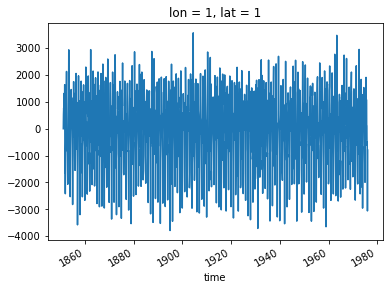

In [11]:
ocean_input.plot()

In [26]:
horiz_input = (horiz_control.sel(lat=0,method='nearest').sel(lon=0,method='nearest').mean('name') - 
               horiz_control.sel(lat=0,method='nearest').sel(lon=0,method='nearest').mean('name').mean('time'))
horiz_input = horiz_input.values
horiz_input

array([20.18016974, 15.34784327, -4.15604845, ..., 18.81875431,
       18.31247307, 17.84955008])

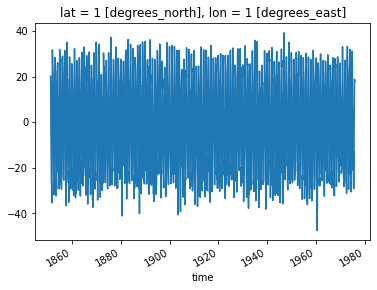

In [13]:
horiz_input.plot()

## Numerical parameters

In [4]:
density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 7*24*60*60 #Time in a week - seconds

# Auto Regression Model

In [38]:
class AutoRegression:
    """
    Class for auto-regression models!
     
    Built with help from https://medium.com/@karen.mossoyan/building-an-autoregression-model-for-time-series-analysis-in-python-49402bdd6d08
    """
    def __init__(self):
        self.order = 1 # Order of model
        self.model = LinearRegression() # Type of model
        self.sigma = None # Generate noise
        
    def generate_train_x(self, X):
        """
        Data to be trained on
        
        """
        n = len(X) 
        
        # Storing values X_1 through X_(n-p) in a column
        ans = X[:n-self.order]
        ans = np.reshape(ans, (-1,1))
        
        for k in range(1, self.order):
          # Analogous to what was done earlier, but for an intermediate column
          temp = X[k:n-self.order+k]
          temp = np.reshape(temp, (-1, 1))
      
          # Stacking them next to each other
          ans = np.hstack((ans, temp))
            
        return ans
    
    def generate_train_y(self, X):
        """
        The target variable
        
        """
        return X[self.order:]
    
    def fit(self, X):
        """
        Assembly
        
        """
        self.sigma = np.std(X)
        train_x = self.generate_train_x(X)
        train_y = self.generate_train_y(X)
        self.model.fit(train_x, train_y)
        
    def predict(self, X, num_predictions, mc_depth):
        """
        Predicts an arbitrary amount of steps into the future and performs a Monte Carlo Simulation.
        
        Variables:
            num_predictions - amount of steps we'll be predicting
            mc_depth - amount of MC simulations of the model we'll be averaging
        """
        X = np.array(X)
        ans = np.array([])
        
        for j in range(mc_depth): 
            ans_temp = []
            a = X[-self.order:] # The last value of the given signal

            # Predicting using a, the trained model, and noise
            for i in range(num_predictions):
                new = self.model.predict(np.reshape(a, (1,-1)) + np.random.normal(loc=0, scale=self.sigma)) 
                ans_temp.append(new)
                # Dropping the oldest value...
                a = np.roll(a, -1)
                # ...and putting the newest one in the front
                a[-1] = new
            
            if j==0:
                ans = np.array(ans_temp)
            else:
                ans += np.array(ans_temp)
            
        # Divide by the amount of MC Simulations we're running!    
        ans /= mc_depth
        
        return ans

# Integration

In [39]:
AutoRegression = AutoRegression()

In [40]:
AutoRegression.fit(ocean_input)

In [41]:
ocean_var = AutoRegression.predict(ocean_input, 10, 5)

In [42]:
ocean_var

array([[-569.62775856],
       [-182.70613975],
       [  84.97264427],
       [-256.06063357],
       [-129.88615261],
       [  71.78530277],
       [ 121.89125253],
       [-192.83671706],
       [-179.90337674],
       [  38.95590087]])